In [1]:
import sys
import time
import datetime
import os
import tensorflow as tf
import argparse
import json
import socket
from PIL import Image
from util import *
import numpy as np
%load_ext autoreload
%autoreload 2
from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib.colors import hsv_to_rgb
%matplotlib inline
from helpers import *
from datetime import datetime

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

with open("hyperParams.json") as f:
    instanceParams = json.load(f)

baseLearningRate = instanceParams["baseLR"]
learningRate = baseLearningRate

photoAlpha = instanceParams["photoParams"]["robustness"]
photoBeta = instanceParams["photoParams"]["scale"]
wei = instanceParams["smoothParams"]["weight"]

In [11]:
# H, W = 448 / 2, 832 / 2
H, W = 448, 832

In [12]:
flow = np.zeros((H, W, 2))
gt = mpimg.imread('../example_data/data/DAVIS/Annotations/480p/train/00023.png')[16:-16,11:-11]
# gt = np.zeros((H, W))

In [14]:
flow = np.expand_dims(flow, 0)
gt = np.expand_dims(np.expand_dims(gt, 0), -1)

flow = tf.cast(flow, tf.float32)
gt = tf.cast(gt, tf.float32)
flow = tf.Variable(flow)

In [15]:
img0 = tf.image.decode_png(tf.read_file("../example_data/data/DAVIS/JPEGImages/480p/train/00023.jpg"), channels=3, dtype=tf.uint8)
img1 = tf.image.decode_png(tf.read_file("../example_data/data/DAVIS/JPEGImages/480p/train/00024.jpg"), channels=3, dtype=tf.uint8)

rgb0 = tf.cast(img0, tf.float32) - [[[[0,0,0]]]]
rgb1 = tf.cast(img1, tf.float32) - [[[[0,0,0]]]]

In [17]:
rgb0 = rgb0[:,16:-16,11:-11,:]
rgb1 = rgb1[:,16:-16,11:-11,:]

rgb0 = tf.image.resize_bilinear(rgb0, [H, W])
rgb1 = tf.image.resize_bilinear(rgb1, [H, W])

In [19]:
def mse_loss(f1, f2):
    return tf.reduce_sum(tf.square(f1 - f2), axis=-1, keep_dims=True)

In [20]:
kernel = tf.transpose(tf.constant([[[[0,-1,0],
                                     [0,1,0],
                                     [0,0,0]]],
                                   [[[0,0,0],
                                     [0,1,-1],
                                     [0,0,0]]],
                                   [[[0,0,0],
                                     [0,1,0],
                                     [0,-1,0]]],
                                   [[[0,0,0],
                                     [-1,1,0],
                                     [0,0,0]]]],
                                  dtype=tf.float32),perm=[3,2,1,0])

In [21]:
w = 1
GT_MASKS = []
for i in range(w):
    GT_MASKS.append(1 - tf.square(tf.nn.atrous_conv2d(gt, kernel, rate=i+1, padding='SAME')))

In [22]:
normalizer = tf.zeros((1, H, W, 2))

multiplier_masks = []
for i in range(w):
    multiplier_masks.append([])

for i in range(w):
    j = i + 1
    gt_mask = GT_MASKS[i]

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([gt_mask[:,:,j:W,0],
                           tf.zeros((1, H, j), dtype=tf.float32)], axis=2), axis=-1), (1, 1, 1, 2)))

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([tf.zeros((1, j, W), dtype=tf.float32),
                           gt_mask[:,0:(H-j),:,1]], axis=1), axis=-1), (1, 1, 1, 2)))

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([tf.zeros((1, H, j), dtype=tf.float32),
                           gt_mask[:,:,0:(W-j),2]], axis=2), axis=-1), (1, 1, 1, 2)))

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([gt_mask[:,j:H,:,3],
                           tf.zeros((1, j, W), dtype=tf.float32)], axis=1), axis=-1), (1, 1, 1, 2)))

    normalizer += multiplier_masks[i][0] + multiplier_masks[i][1] + multiplier_masks[i][2] + multiplier_masks[i][3]

# Remove 0's in normalizer
normalizer += 4 * w * tf.cast(tf.equal(normalizer, 0), dtype=tf.float32)
normalizer.shape

TensorShape([Dimension(1), Dimension(448), Dimension(832), Dimension(2)])

In [23]:
def fixed_point_update(flow, gamma, itr):
    flow_copy1 = flow * 1.0
    flow_copy2 = flow * 1.0
    flow_copy1 = tf.stop_gradient(flow_copy1)
    flow_copy2 = tf.stop_gradient(flow_copy2)

    for k in range(itr):
        temp = tf.zeros_like(flow)
        for i in range(w):
            j = i + 1
            temp += tf.concat([flow_copy1[:,:,j:W,:],
                               tf.zeros((1, H, j, 2), dtype=tf.float32)], axis=2) * multiplier_masks[i][0]

            temp += tf.concat([tf.zeros((1, j, W, 2), dtype=tf.float32),
                               flow_copy1[:,0:(H-j),:,:]], axis=1) * multiplier_masks[i][1]

            temp += tf.concat([tf.zeros((1, H, j, 2), dtype=tf.float32),
                               flow_copy1[:,:,0:(W-j),:]], axis=2) * multiplier_masks[i][2]

            temp += tf.concat([flow_copy1[:,j:H,:,:],
                               tf.zeros((1, j, W, 2), dtype=tf.float32)], axis=1) * multiplier_masks[i][3]

        temp += gamma * flow_copy2
        flow_copy1 = temp / (normalizer + gamma)
    return flow_copy1

In [24]:
gammaTensor = tf.placeholder(tf.float32,shape=[])
golTensor = tf.placeholder(tf.float32,shape=[])
inner_itr = 1

def adm_loss_fn(flow, gol, gamma):
    pLoss = photoLoss(flow, rgb0, rgb1, photoAlpha, 1)
    actual_smooth_loss = asymmetricSmoothLoss(flow, gt, instanceParams, 1, 1, None, instanceParams["boundaryAlpha"], True)
    actual_smooth_loss = tf.stop_gradient(actual_smooth_loss)
    fhat = fixed_point_update(flow, gol, inner_itr)
    sLoss = asymmetricSmoothLoss(fhat, gt, instanceParams, 1, 1, None, instanceParams["boundaryAlpha"], True)
    mLoss = mse_loss(flow, fhat)
    # mLoss = mse_loss(flow, tf.zeros_like(flow))

    return pLoss, sLoss, gamma * mLoss, actual_smooth_loss, fhat


In [25]:
photo_loss, smooth_loss, eucl_loss, as_loss, fhat = adm_loss_fn(flow, golTensor, gammaTensor)
adm_loss = photo_loss + smooth_loss + eucl_loss

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [26]:
sGrad = tf.gradients(smooth_loss, fhat)
pGrad = tf.gradients(photo_loss, flow)
mGrad = tf.gradients(eucl_loss, flow)
tGrad = tf.gradients(adm_loss, flow)

In [27]:
momentum1 = 0.9
momentum2 = 0.999

def attach_SGD_Solver(loss):
    with tf.variable_scope(None,default_name="solver"):
        learningRate = tf.placeholder(tf.float32,shape=[])
        solver = tf.train.GradientDescentOptimizer(learning_rate=learningRate)
        solver_op = solver.minimize(loss)
        return [solver, solver_op, learningRate]
    
def attach_ADAM_Solver(loss):
    with tf.variable_scope(None,default_name="solver"):
        learningRate = tf.placeholder(tf.float32,shape=[])
        solver = tf.train.AdamOptimizer(learning_rate=learningRate , beta1=momentum1, beta2=momentum2)
        solver_op = solver.minimize(loss)
        return [solver, solver_op, learningRate]

In [28]:
solver, solver_op, learningRateTensor = attach_ADAM_Solver(adm_loss)

In [29]:
itr = 2000
lambda_ = 10000

In [30]:
init = tf.global_variables_initializer()
mLosses, sLosses, pLosses, asLosses = [], [], [], []
tGrads, sGrads, pGrads, mGrads = [], [], [], []
flows, flow_props = [], []

print_freq = 10
with tf.Session() as sess:
    sess.run(init)
    for i in range(1, itr + 2):
        feed_dict = {
            learningRateTensor: 1,
            gammaTensor: 10 * lambda_,
            golTensor: 10
        }
        _, s, p, m, f, fp, asl, pg, mg = sess.run([solver_op,
                                      smooth_loss,
                                      photo_loss,
                                      eucl_loss,
                                      flow,
                                      fhat,
                                      as_loss,
                                      pGrad,
                                      mGrad], feed_dict = feed_dict)

        if i % print_freq == 1:
            print(i)
            flows.append(deepcopy(f[0]))
            flow_props.append(deepcopy(fp[0]))
            sLosses.append(np.mean(s))
            asLosses.append(np.mean(asl))
            pLosses.append(np.mean(p))
            mLosses.append(np.mean(m))
            pGrads.append(np.median(np.abs(pg[0])))
            mGrads.append(np.median(np.abs(mg[0])))
            print "Photo loss: %f" % float(pLosses[-1])
            print "Smooth loss after fixed point update: %f" % sLosses[-1]
            print "Smooth loss after fixed point update without border: %f" % np.mean(s[:,1:-1,1:-1,:])
            print "Smooth loss from \"network\": %f" % np.mean(asl)
            print "Smooth loss from \"network\" without border: %f" % np.mean(asl[:,1:-1,1:-1,:])

1
Photo loss: 2944.343994
Smooth loss after fixed point update: 0.000004
Smooth loss after fixed point update without border: 0.000004
Smooth loss from "network": 0.000004
Smooth loss from "network" without border: 0.000004
11
Photo loss: 1560.169678
Smooth loss after fixed point update: 0.612482
Smooth loss after fixed point update without border: 0.610788
Smooth loss from "network": 1.225794
Smooth loss from "network" without border: 1.224807
21
Photo loss: 1358.158447
Smooth loss after fixed point update: 0.208001
Smooth loss after fixed point update without border: 0.205268
Smooth loss from "network": 0.370248
Smooth loss from "network" without border: 0.367589
31
Photo loss: 1202.085815
Smooth loss after fixed point update: 0.101755
Smooth loss after fixed point update without border: 0.097791
Smooth loss from "network": 0.156749
Smooth loss from "network" without border: 0.152764
41
Photo loss: 1072.000977
Smooth loss after fixed point update: 0.066978
Smooth loss after fixed poi

371
Photo loss: 238.343475
Smooth loss after fixed point update: 0.045761
Smooth loss after fixed point update without border: 0.014420
Smooth loss from "network": 0.048362
Smooth loss from "network" without border: 0.016946
381
Photo loss: 234.099197
Smooth loss after fixed point update: 0.045560
Smooth loss after fixed point update without border: 0.014188
Smooth loss from "network": 0.048156
Smooth loss from "network" without border: 0.016708
391
Photo loss: 229.158142
Smooth loss after fixed point update: 0.045345
Smooth loss after fixed point update without border: 0.013947
Smooth loss from "network": 0.048004
Smooth loss from "network" without border: 0.016529
401
Photo loss: 225.310074
Smooth loss after fixed point update: 0.045134
Smooth loss after fixed point update without border: 0.013710
Smooth loss from "network": 0.047807
Smooth loss from "network" without border: 0.016306
411
Photo loss: 221.680588
Smooth loss after fixed point update: 0.044966
Smooth loss after fixed po

741
Photo loss: 190.408661
Smooth loss after fixed point update: 0.044665
Smooth loss after fixed point update without border: 0.012769
Smooth loss from "network": 0.050392
Smooth loss from "network" without border: 0.018426
751
Photo loss: 190.282501
Smooth loss after fixed point update: 0.044637
Smooth loss after fixed point update without border: 0.012732
Smooth loss from "network": 0.050405
Smooth loss from "network" without border: 0.018427
761
Photo loss: 189.524689
Smooth loss after fixed point update: 0.044642
Smooth loss after fixed point update without border: 0.012758
Smooth loss from "network": 0.050626
Smooth loss from "network" without border: 0.018672
771
Photo loss: 189.122452
Smooth loss after fixed point update: 0.044600
Smooth loss after fixed point update without border: 0.012738
Smooth loss from "network": 0.050614
Smooth loss from "network" without border: 0.018684
781
Photo loss: 188.543030
Smooth loss after fixed point update: 0.044593
Smooth loss after fixed po

Photo loss: 179.637924
Smooth loss after fixed point update: 0.044485
Smooth loss after fixed point update without border: 0.012550
Smooth loss from "network": 0.052822
Smooth loss from "network" without border: 0.020828
1121
Photo loss: 179.697922
Smooth loss after fixed point update: 0.044569
Smooth loss after fixed point update without border: 0.012628
Smooth loss from "network": 0.053328
Smooth loss from "network" without border: 0.021334
1131
Photo loss: 179.268677
Smooth loss after fixed point update: 0.044528
Smooth loss after fixed point update without border: 0.012595
Smooth loss from "network": 0.053113
Smooth loss from "network" without border: 0.021123
1141
Photo loss: 178.887207
Smooth loss after fixed point update: 0.044573
Smooth loss after fixed point update without border: 0.012629
Smooth loss from "network": 0.053294
Smooth loss from "network" without border: 0.021287
1151
Photo loss: 178.674133
Smooth loss after fixed point update: 0.044583
Smooth loss after fixed po

1491
Photo loss: 171.789291
Smooth loss after fixed point update: 0.044389
Smooth loss after fixed point update without border: 0.012412
Smooth loss from "network": 0.054381
Smooth loss from "network" without border: 0.022343
1501
Photo loss: 171.932510
Smooth loss after fixed point update: 0.044428
Smooth loss after fixed point update without border: 0.012432
Smooth loss from "network": 0.054561
Smooth loss from "network" without border: 0.022503
1511
Photo loss: 171.685501
Smooth loss after fixed point update: 0.044282
Smooth loss after fixed point update without border: 0.012291
Smooth loss from "network": 0.053748
Smooth loss from "network" without border: 0.021695
1521
Photo loss: 171.689484
Smooth loss after fixed point update: 0.044276
Smooth loss after fixed point update without border: 0.012291
Smooth loss from "network": 0.053775
Smooth loss from "network" without border: 0.021731
1531
Photo loss: 171.520844
Smooth loss after fixed point update: 0.044273
Smooth loss after fix

Photo loss: 164.386536
Smooth loss after fixed point update: 0.043582
Smooth loss after fixed point update without border: 0.011597
Smooth loss from "network": 0.053995
Smooth loss from "network" without border: 0.021947
1871
Photo loss: 164.190414
Smooth loss after fixed point update: 0.043374
Smooth loss after fixed point update without border: 0.011416
Smooth loss from "network": 0.052998
Smooth loss from "network" without border: 0.020972
1881
Photo loss: 164.352325
Smooth loss after fixed point update: 0.043422
Smooth loss after fixed point update without border: 0.011450
Smooth loss from "network": 0.053236
Smooth loss from "network" without border: 0.021194
1891
Photo loss: 164.492401
Smooth loss after fixed point update: 0.043374
Smooth loss after fixed point update without border: 0.011398
Smooth loss from "network": 0.052953
Smooth loss from "network" without border: 0.020922
1901
Photo loss: 164.362076
Smooth loss after fixed point update: 0.043422
Smooth loss after fixed po

max flow: 8.7383
flow range:
u = -4.515 .. 8.581
v = -7.915 .. 4.147


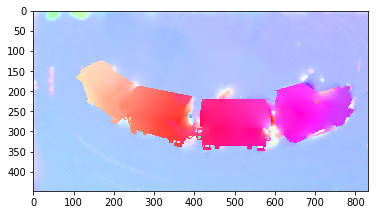

In [31]:
plt.imshow(flow_to_image(flows[-1]))

In [29]:
mLosses = np.array(mLosses)
sLosses = np.array(sLosses)
pLosses = np.array(pLosses)
asLosses = np.array(asLosses)

tLosses = pLosses + mLosses + lambda_ * sLosses

In [32]:
f = tf.cast(np.expand_dims(flows[-1], 0), tf.float32)
f.shape

TensorShape([Dimension(1), Dimension(448), Dimension(832), Dimension(2)])

In [44]:
l = photoLoss(f, rgb0, rgb1, photoAlpha, 1)

In [45]:
np.mean(l.eval(session=tf.Session()))

164.2794

In [46]:
g = tf.gradients(l, f)

In [47]:
l -= 1e-4 * g[0]

In [48]:
np.mean(l.eval(session=tf.Session()))

164.51697